In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

In [5]:
import numpy as np

회귀분석기반의 주요인변수들을 -1 ~ 1 MaxAbs정규화

In [6]:
coef = [1866.6567 , -4861.4769, 75.4095, 5.6919,  -71.2653]
coef = np.array(coef)

In [7]:
coef = coef.reshape(5,1)

In [8]:
scaler_coef = scaler.fit_transform(coef)
scaler_coef

array([[ 0.38396906],
       [-1.        ],
       [ 0.01551164],
       [ 0.00117082],
       [-0.01465919]])

In [9]:
scaler_coef.round(3)

array([[ 0.384],
       [-1.   ],
       [ 0.016],
       [ 0.001],
       [-0.015]])

In [10]:
path = '/content/drive/MyDrive/데청캠 프로젝트/dataset/시군구별_인프라수_청년수.csv'
df = pd.read_csv(path, encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)
df['청년인구'] = df['청년인구'].str.replace(",","")
df['청년인구'] = df['청년인구'].astype('float64')

In [11]:
df = df.drop([22,0,1])

In [12]:
df.columns

Index(['시군구', '청년인구', '병원', '사회스포츠', '대학교', '초중고', '공항', '소방서', '경찰서',
       '소형상업시설(음식점_카페_학원_편의점)', '대형상업시설', '숙박시설', '기차역', '행정기관', '법원, 교도소',
       '문화시설_영화/공연/미술관박물관', '버스터미널'],
      dtype='object')

## 회귀분석기반 지수구하기

In [13]:
df['단순지수'] = df['경찰서'] * 0.384 + df['법원, 교도소'] * -1 + df['병원'] * 0.016 + df['소형상업시설(음식점_카페_학원_편의점)'] * 0.001 + df['숙박시설'] * -0.015  
df['단순지수'] = df['단순지수'] * 3.3

In [14]:
df.sort_values(by=['단순지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,단순지수
23,서울_송파구,143645.0,1215,108.0,1,139.0,0,1,11,8807,46,52,1,29.0,2.0,37.0,0.0,97.9803
21,서울_서초구,81935.0,1279,172.0,1,80.0,0,1,13,8169,29,80,0,20.0,6.0,62.0,3.0,87.2025
15,서울_강서구,136535.0,880,143.0,1,136.0,1,1,11,7638,34,92,1,30.0,0.0,17.0,0.0,81.0546
53,인천_남동구,101919.0,745,111.0,0,155.0,0,2,12,7520,32,63,5,22.0,0.0,12.0,0.0,76.2399
47,대구_달서구,107479.0,822,180.0,3,191.0,0,1,14,8913,35,101,0,24.0,3.0,15.0,0.0,75.6558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,부산_서구,18425.0,145,53.0,0,33.0,0,0,5,1663,9,68,0,15.0,0.0,8.0,0.0,16.1139
25,부산_중구,8049.0,140,15.0,0,14.0,0,1,6,2058,21,125,0,11.0,0.0,21.0,0.0,15.5991
57,인천_강화군,7579.0,87,120.0,1,56.0,0,1,14,1998,2,305,1,14.0,1.0,19.0,1.0,10.5303
50,인천_동구,9546.0,90,41.0,1,27.0,0,0,3,990,9,37,4,12.0,0.0,6.0,0.0,9.9891


In [15]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

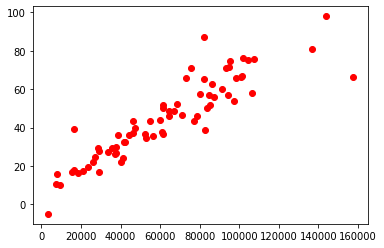

In [16]:
plt.plot(df['청년인구'], df['단순지수'], 'ro')

인프라수만으로 구한 지수가 청년인구대비 비례하는 상관관계가 보임

그래프 해석 : 위로 치우쳐 질수록 인프라대비 청년인구부족 and 아래로 치우쳐질수록 인프라대비 청년인구과잉

단순지수로 청년인구 기대치값을 구할수있다?

In [17]:
# 예측모델
# 예측값 - 실제값

## 청년인구 예측모델

In [18]:
# !pip install catboost
# !pip install pycaret
# !pip install optuna # 하이퍼 파라미터

In [19]:
from sklearn.preprocessing import StandardScaler

# for "4. Modeling with Pycaret"
from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error

In [20]:
path = '/content/drive/MyDrive/데청캠 프로젝트/dataset/시군구별_인프라수_청년수.csv'
df = pd.read_csv(path, encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)
df['청년인구'] = df['청년인구'].str.replace(",","")
df['청년인구'] = df['청년인구'].astype('float64')
df = df.drop([22,0,1])

In [21]:
items = df.columns
need_list = ['병원', '법원, 교도소', '경찰서', '소형상업시설(음식점_카페_학원_편의점)',  '숙박시설']
need_list2 = ['병원',	'법원교도소',	'경찰서',	'소형상업시설' ,'숙박시설']
del_list = items.drop(need_list)

In [22]:
X = df[need_list]
y = df['청년인구']
df_data = pd.concat([y,X] , axis=1)


In [23]:
df_data = df_data.astype('float64')

In [24]:
std_scaler = StandardScaler()

In [25]:
df_data.loc[:,need_list] = std_scaler.fit_transform(df_data[need_list])
df_data.columns = ['청년인구',	'병원',	'법원교도소',	'경찰서',	'소형상업시설' ,'숙박시설']
X = df_data[need_list2]
y = df_data['청년인구']

In [26]:
reg = setup(df_data, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '청년인구', 
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(df_data.drop(columns = ['청년인구']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,청년인구
2,Original Data,"(72, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Transformed Train Set,"(71, 5)"
7,Transformed Test Set,"(1, 5)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [27]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,10601.2662,2.300105e+08,14023.9841,0.6959,0.3061,0.3236,0.021
ridge,Ridge Regression,10920.0777,2.299411e+08,14143.7012,0.6987,0.3105,0.3363,0.014
br,Bayesian Ridge,10934.1748,2.293762e+08,14121.6012,0.7003,0.3120,0.3374,0.016
llar,Lasso Least Angle Regression,10937.7391,2.317172e+08,14204.5013,0.6953,0.3107,0.3394,0.015
lasso,Lasso Regression,10937.9458,2.317040e+08,14204.4460,0.6954,0.3107,0.3396,0.015
lr,Linear Regression,10937.9733,2.317011e+08,14204.3827,0.6954,0.3107,0.3396,0.336
lar,Least Angle Regression,10937.9752,2.317011e+08,14204.3837,0.6954,0.3107,0.3396,0.015
rf,Random Forest Regressor,11764.1193,2.882969e+08,16124.5054,0.6113,0.2883,0.2634,0.415
et,Extra Trees Regressor,11803.3849,2.856215e+08,15940.2980,0.6272,0.2847,0.2628,0.364
ada,AdaBoost Regressor,12093.9060,2.977558e+08,16372.4038,0.6104,0.3316,0.3196,0.083


In [28]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 10))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10514.0312,1.519940e+08,12328.5830,0.6918,0.1776,0.1672
1,8624.2510,1.018606e+08,10092.6016,0.8843,0.1618,0.1487
2,9541.9043,1.376681e+08,11733.2051,0.7361,0.1760,0.1463
3,14473.2334,4.172890e+08,20427.6523,0.0449,0.2367,0.1618
4,8198.7764,1.512460e+08,12298.2090,0.8908,0.3725,0.3043
5,8058.7104,8.145044e+07,9024.9902,0.8770,0.1545,0.1512
6,13862.0049,3.099328e+08,17604.9082,0.4226,0.4968,0.4868
7,7765.8110,9.357675e+07,9673.5078,0.7927,0.1602,0.1444
8,18384.9102,7.344769e+08,27101.2344,0.6748,0.7650,1.3013
9,9942.6270,1.385667e+08,11771.4375,0.9360,0.4061,0.3749


In [29]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10075.2719,1.305333e+08,11425.1160,0.7353,0.1715,0.1603
1,8490.0514,9.917937e+07,9958.8842,0.8873,0.1665,0.1499
2,9349.7269,1.381469e+08,11753.5911,0.7352,0.1749,0.1419
3,14652.8075,4.361524e+08,20884.2624,0.0017,0.2352,0.1622
4,8125.2392,1.369772e+08,11703.7268,0.9011,0.3742,0.3093
5,7874.6775,7.970968e+07,8928.0279,0.8796,0.1520,0.1479
6,13617.1239,2.988421e+08,17287.0493,0.4433,0.4888,0.4740
7,7617.3103,8.540401e+07,9241.4292,0.8108,0.1560,0.1462
8,18148.4460,7.279005e+08,26979.6308,0.6777,0.7413,1.2356
9,9746.1363,1.508250e+08,12281.0821,0.9304,0.4248,0.3839


In [30]:
voting.weights

[0.8300000000000001,
 0.29000000000000004,
 0.9400000000000001,
 0.19,
 0.09999999999999999]

In [31]:
layer1_pred = voting.predict(df_data.drop(columns = ['청년인구']))
layer1_pred

array([ 51794.72183876,  69608.67914395,  86653.62292935,  81085.89047077,
        69693.91856958,  81744.57496171,  60335.80668619,  51783.17343505,
        93411.12327805,  93572.47206506,  66203.23900707, 101989.8280156 ,
        78319.10606596, 116023.07592738,  71940.23182035,  49630.33940282,
       102089.15365338,  74741.82489549,  94729.2205552 , 112806.66410242,
       135797.65902261, 105290.56816045,  19696.97111772,  20063.82024416,
        20970.98011617,  22997.65137663,  99580.1007397 ,  59560.41284637,
        56186.87464872,  46686.74068885,  72471.19705511,  61608.09254961,
        50539.15230643,  25340.20532981,  31010.16568404,  39482.20267443,
        28451.00048432,  35066.80855638,  53670.26616322,  72403.94447558,
        38230.33064609,  40418.26256457,  92119.58542181,  90045.90457248,
       106903.72611424,  53505.0189076 ,  23834.43830136,  10535.46280512,
        51001.96238715,  62168.96301786, 110962.89737536,  96502.63285254,
        51017.78294455,  

In [32]:
df_data['청년인구']

2     52554.0
3     67271.0
4     91126.0
5     80217.0
6     83722.0
       ...   
70    64670.0
71    26280.0
72    41455.0
73    37605.0
74    64602.0
Name: 청년인구, Length: 72, dtype: float64

## huber

In [33]:
from sklearn.linear_model import HuberRegressor, LinearRegression

In [34]:
huber = HuberRegressor().fit(X, y)

In [35]:
huber.score(X, y)

0.8254001792301644

In [36]:
huber.predict(X)

array([ 50669.17887607,  68344.15709252,  84847.71469227,  80198.05039981,
        69260.88505221,  80057.49737611,  59987.17660099,  52283.0228529 ,
        93526.13375748,  92709.46963513,  64817.7246378 , 100601.76142539,
        79480.91764941, 114693.30941107,  71995.82733721,  48904.09426466,
       100536.05119969,  75002.71281454,  93457.46342122, 120757.65630868,
       138041.91826672, 104965.10976468,  19226.48915467,  20036.93682348,
        20807.62178841,  22716.23798707,  98779.81246269,  59067.71727056,
        55189.62729571,  46434.05392378,  71710.52538815,  60534.44440023,
        49732.67364584,  25760.19937769,  34333.26480282,  38964.13604907,
        28965.06269126,  33526.92180497,  53495.4292502 ,  69960.54281885,
        37346.96323759,  39662.32465113,  89246.70086252,  91882.6047096 ,
       107433.35859229,  52510.92428986,  21319.12425167,  10985.79368896,
        52748.80843182,  60234.25889033, 108694.42909128,  94159.23031154,
        50442.62069753,  

In [41]:
# 변수의 가중치값
huber.coef_

array([18353.21255524, -5797.00036004,  5342.1988369 , 10818.52961357,
       -5267.55126726])

In [50]:
coef = huber.coef_
coef = coef/5000
coef

array([ 3.67064251, -1.15940007,  1.06843977,  2.16370592, -1.05351025])

In [75]:
path = '/content/drive/MyDrive/데청캠 프로젝트/dataset/시군구별_인프라수_청년수.csv'
df = pd.read_csv(path, encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)
df['청년인구'] = df['청년인구'].str.replace(",","")
df['청년인구'] = df['청년인구'].astype('float64')
df = df.drop([22,0,1])

In [76]:
coef[0]

3.670642511047812

In [77]:
df['청년인프라지수'] = df[need_list[0]] * coef[0] + df[need_list[1]] * coef[1] + df[need_list[2]] * coef[2] + df[need_list[3]] * coef[3] + df[need_list[4]] * coef[4]
df.sort_values(by=['청년인프라지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수
66,대전_서구,104642.0,896,66.0,3,165.0,0,2,11,9410,42,79,2,25.0,4.0,29.0,2.0,23573.256350
23,서울_송파구,143645.0,1215,108.0,1,139.0,0,1,11,8807,46,52,1,29.0,2.0,37.0,0.0,23470.240216
21,서울_서초구,81935.0,1279,172.0,1,80.0,0,1,13,8169,29,80,0,20.0,6.0,62.0,3.0,22292.717951
47,대구_달서구,107479.0,822,180.0,3,191.0,0,1,14,8913,35,101,0,24.0,3.0,15.0,0.0,22207.454454
13,서울_마포구,93492.0,761,98.0,2,72.0,0,1,9,8638,31,115,2,18.0,1.0,77.0,0.0,21370.753590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,부산_영도구,16436.0,142,46.0,2,41.0,0,1,5,1906,5,48,0,13.0,0.0,6.0,0.0,4600.028432
57,인천_강화군,7579.0,87,120.0,1,56.0,0,1,14,1998,2,305,1,14.0,1.0,19.0,1.0,4334.908461
26,부산_서구,18425.0,145,53.0,0,33.0,0,0,5,1663,9,68,0,15.0,0.0,8.0,0.0,4064.189615
50,인천_동구,9546.0,90,41.0,1,27.0,0,0,3,990,9,37,4,12.0,0.0,6.0,0.0,2436.652129


### 단순 가중치 반영 : 인구수 대비 비교파악이 필요 

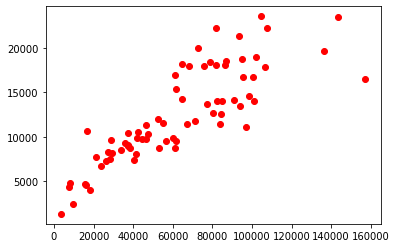

In [78]:
plt.plot(df['청년인구'], df['청년인프라지수'], 'ro')

In [79]:
df['청년인프라지수'] = df['청년인구']/ df['청년인프라지수']

In [85]:
df['청년인프라지수'].mean()

4.825398825165709

In [80]:
df.sort_values(by=['청년인프라지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수
20,서울_관악구,157264.0,706,140.0,1,91.0,0,1,10,6461,27,98,0,23.0,0.0,17.0,0.0,9.543519
19,서울_동작구,97181.0,601,105.0,3,78.0,0,1,8,4143,19,30,1,17.0,0.0,10.0,0.0,8.717949
6,서울_중랑구,83722.0,539,96.0,1,76.0,0,1,9,4410,14,89,7,18.0,0.0,5.0,1.0,7.320742
10,서울_노원구,101260.0,747,205.0,6,159.0,0,1,9,5218,25,26,3,21.0,0.0,19.0,0.0,7.225419
9,서울_도봉구,61212.0,370,90.0,1,71.0,0,1,9,3429,15,21,5,16.0,1.0,12.0,0.0,6.984627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,광주_동구,21164.0,231,115.0,3,40.0,0,1,6,3261,25,128,0,14.0,2.0,42.0,0.0,2.722756
58,인천_옹진군,3526.0,28,27.0,0,26.0,0,0,6,733,0,333,0,7.0,0.0,1.0,0.0,2.622797
57,인천_강화군,7579.0,87,120.0,1,56.0,0,1,14,1998,2,305,1,14.0,1.0,19.0,1.0,1.748364
25,부산_중구,8049.0,140,15.0,0,14.0,0,1,6,2058,21,125,0,11.0,0.0,21.0,0.0,1.662495


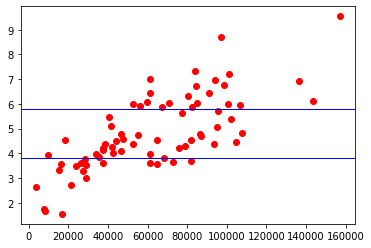

In [88]:
plt.plot(df['청년인구'], df['청년인프라지수'], 'ro')
plt.axhline(y=5.8, color='b', linewidth=1)
plt.axhline(y=3.8, color='b', linewidth=1)


### 청년인구 / 가중치값 : 지수가 클수록 인프라대비 청년인구가 많다.

### + 평균 지수에 가까울수록 적정인구이다 *

의미부여 : 도시인구집중 문제를 해결하기위해 신도시개발을 할때  해당 지수를 사용시 목표도시인구를 인프라설계에 도움을 줄수있다?

In [92]:
df[df['시군구']=='세종시']['청년인프라지수']

74    4.538125
Name: 청년인프라지수, dtype: float64

세종시에 청년인구를 더 수용할수있는 인프라를 가지고 있다.